In [2]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

#### Using TF-IDF - Content based recommendation


Data Preprocessing

In [3]:
# contains user_id, MAL_ID, rating
top_animes_count = 1000
rating_top_anime = pd.read_csv('dataset/top_anime_unsupervised_use.csv')

# contains all anime info
anime_data = pd.read_csv('dataset/anime.csv')
anime_df = anime_data[['MAL_ID', 'Name', 'Genres', 'Type', 'Producers', 'Source', 'Completed', 'Japanese name', 'English name', 'Score']]

In [4]:
usecols = ['MAL_ID', 'Name', 'sypnopsis']
anime_with_synopsis = pd.read_csv('dataset/anime_with_synopsis.csv', usecols=usecols)

In [5]:
pd.set_option("display.max_columns", 50)
anime_df.head()

,MAL_ID,Name,Genres,Type,Producers,Source,Completed,Japanese name,English name,Score
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Bandai Visual,Original,718161,カウボーイビバップ,Cowboy Bebop,8.78
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,"Sunrise, Bandai Visual",Original,208333,カウボーイビバップ 天国の扉,Cowboy Bebop:The Movie,8.39
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,Victor Entertainment,Manga,343492,トライガン,Trigun,8.24
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",TV,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Original,46165,Witch Hunter ROBIN (ウイッチハンターロビン),Witch Hunter Robin,7.27
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",TV,"TV Tokyo, Dentsu",Manga,7314,冒険王ビィト,Beet the Vandel Buster,6.98


In [6]:
anime_df.reset_index(drop=True, inplace=True)

#### Content based filtering: using sypnopsis for keyword search and recommendation

In [7]:
def process_multilabel(series):
    series = series.split(",")
    if "Unknown" in series:
        series.remove("Unknown")
    return series

In [8]:
anime_data["Genres"] = anime_data["Genres"].map(process_multilabel)
anime_data["Producers"] = anime_data["Producers"].map(process_multilabel)
anime_data["Score"] = anime_data["Score"].replace("Unknown", 0).astype(float)
anime_data.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"[Action, Adventure, Comedy, Drama, Sci-Fi,...",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,[Bandai Visual],"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"[Action, Drama, Mystery, Sci-Fi, Space]",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"[Sunrise, Bandai Visual]",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"[Action, Sci-Fi, Adventure, Comedy, Drama,...",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,[Victor Entertainment],"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"[Action, Mystery, Police, Supernatural, Dr...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"[TV Tokyo, Bandai Visual, Dentsu, Victor En...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"[Adventure, Fantasy, Shounen, Supernatural]",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"[TV Tokyo, Dentsu]",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [9]:
def to_category(df, column, is_multilabel=False):
    lb = LabelBinarizer()
    if is_multilabel:
        lb = MultiLabelBinarizer()
        
    expandedLabelData = lb.fit_transform(df[column])
    labelClasses = lb.classes_

    category_df = pd.DataFrame(expandedLabelData, columns=labelClasses)
    del df[column]
    return pd.concat([df, category_df], axis=1)

In [10]:
anime_metadata = anime_data[['MAL_ID', 'Name', 'Genres', 'Japanese name', 'Type', 'Producers', 'Source']].copy()

anime_metadata = to_category(anime_metadata, 'Source')
anime_metadata = to_category(anime_metadata, 'Producers', is_multilabel=True)
anime_metadata = to_category(anime_metadata, 'Type')
anime_metadata = to_category(anime_metadata, 'Genres', is_multilabel=True)

# genres_col = anime_metadata["Genres"]
anime_id = anime_metadata[['MAL_ID', 'Name', 'Japanese name']]

# del anime_metadata["Genres"]
del anime_metadata['MAL_ID']
del anime_metadata['Name']
del anime_metadata['Unknown']
del anime_metadata['Japanese name']

print(anime_metadata.shape)
anime_metadata.head()

(17562, 1926)


,4-koma manga,Book,Card game,Digital manga,Game,Light novel,Manga,Music,Novel,Original,Other,Picture book,Radio,Visual novel,Web manga,12 Diary Holders,1st PLACE,1theK,3xCube,4Kids Entertainment,5pb.,81 Produce,A-1 Pictures,A-Craft,A-Line,...,Magic,Martial Arts,Mecha,Military,Music,Mystery,Parody,Police,Psychological,Romance,Samurai,School,Sci-Fi,Seinen,Shoujo,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# allow search by japanese name or english name
def search_anime(keyword):
    query1 = anime_data['Japanese name'].str.contains(keyword, case=False)
    query2 = anime_data['English name'].str.contains(keyword, case=False)
    print(anime_data[query1 | query2][['Name', 'Japanese name']].head(20))
    return anime_data[query1 | query2].head(1).index

In [12]:
anime_id = anime_data['MAL_ID'].copy()
anime_metadata2 = pd.merge(anime_id, anime_with_synopsis, on='MAL_ID', how='left').fillna('').astype(str)
anime_metadata2.head()

,MAL_ID,Name,sypnopsis
0,1,Cowboy Bebop,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"other day, another bounty—such is the life of ..."
2,6,Trigun,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,It is the dark century and the people are suff...


In [13]:
tfv = TfidfVectorizer(min_df=3, max_features=None,
                      strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1, 3),
                      stop_words = 'english')

synopsis_original = anime_metadata2['sypnopsis']
synopsis_vector_tf_idf = tfv.fit_transform(synopsis_original)
synopsis_vector_tf_idf.shape

(17562, 38694)

In [14]:
all_meta_data = np.concatenate((anime_metadata.values, synopsis_vector_tf_idf.todense()), axis=1)

# create knn model
cb_model_knn = NearestNeighbors(metric='cosine', n_neighbors=9)
cb_model_knn.fit(csr_matrix(all_meta_data))

NearestNeighbors(metric='cosine', n_neighbors=9)

In [15]:
def cb_recommend_anime(query_index):
    distances, indices = cb_model_knn.kneighbors(all_meta_data[query_index,:].reshape(1, -1), n_neighbors=11)
    result = []
    for i in range(0, len(distances.flatten())):
        index = indices.flatten()[i]
        if index == query_index:
            continue
        result.append(anime_data.iloc[index])
        
    return pd.DataFrame(result)

In [16]:
cb_recommend_anime(search_anime('進撃の巨人'))

                                                    Name  \
7449                                  Shingeki no Kyojin   
7879                              Shingeki no Kyojin OVA   
8052                     Shingeki no Kyojin: Ano Hi Kara   
8068                    Shingeki no Kyojin Picture Drama   
9018         Shingeki no Kyojin Movie 1: Guren no Yumiya   
9019        Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa   
9383                         Shingeki no Kyojin Season 2   
9384                 Shingeki no Kyojin: Kuinaki Sentaku   
12946         Shingeki no Kyojin-ten 360° Taikan Theater   
13252                        Shingeki no Kyojin Season 3   
13428                     Shingeki no Kyojin: Lost Girls   
13804  Shingeki no Kyojin Season 2 Movie: Kakusei no ...   
13999      Animegatari x Shingeki no Kyojin Collab Eizou   
14963                 Shingeki no Kyojin Season 3 Part 2   
15626               Shingeki no Kyojin Season 3 Specials   
15627  Shingeki no Kyojin in the Dome: H

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
13252,35760,Shingeki no Kyojin Season 3,8.59,"[Action, Military, Mystery, Super Power, D...",Attack on Titan Season 3,進撃の巨人 Season3,TV,12,"Jul 23, 2018 to Oct 15, 2018",Summer 2018,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,23 min. per ep.,R - 17+ (violence & profanity),76.0,48,1212430,14971,62604,991045,10271,6048,142462,194692.0,256697.0,215524.0,78551.0,19822.0,6215.0,2442.0,967.0,459.0,1285.0
9383,25777,Shingeki no Kyojin Season 2,8.45,"[Action, Military, Mystery, Super Power, D...",Attack on Titan Season 2,進撃の巨人 Season2,TV,12,"Apr 1, 2017 to Jun 17, 2017",Spring 2017,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,24 min. per ep.,R - 17+ (violence & profanity),128.0,16,1591506,18262,72638,1337762,15022,12637,153447,239823.0,308956.0,304020.0,135241.0,38504.0,12841.0,5160.0,1716.0,839.0,1804.0
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.10,"[Action, Drama, Fantasy, Military, Mystery...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,23 min. per ep.,R - 17+ (violence & profanity),4.0,63,1073626,40985,54607,906824,5533,3099,103563,327290.0,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"[Action, Military, Mystery, Super Power, D...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,MAPPA,Manga,23 min. per ep.,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720,173154.0,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0
16841,42091,Shingeki no Kyojin: Chronicle,7.68,"[Action, Military, Mystery, Super Power, D...",Unknown,進撃の巨人 〜クロニクル〜,Movie,1,"Jul 17, 2020",Unknown,"[Production I.G, Dentsu, Mainichi Broadcasti...",Unknown,Wit Studio,Manga,2 hr.,R - 17+ (violence & profanity),1089.0,2249,50634,211,1352,15917,475,605,32285,1736.0,1468.0,2993.0,2858.0,998.0,437.0,103.0,52.0,26.0,60.0
13804,36702,Shingeki no Kyojin Season 2 Movie: Kakusei no ...,7.76,"[Action, Drama, Fantasy, Shounen, Super Po...",Unknown,劇場版 進撃の巨人 Season2〜覚醒の咆哮〜,Movie,1,"Jan 13, 2018",Unknown,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,2 hr.,R - 17+ (violence & profanity),903.0,2448,43227,82,1109,17792,560,542,23224,1691.0,1489.0,3218.0,2651.0,838.0,341.0,93.0,36.0,26.0,62.0
8052,19285,Shingeki no Kyojin: Ano Hi Kara,7.14,"[Action, Drama, Fantasy, Shounen, Super Po...",Attack on Titan:Since That Day,進撃の巨人 総集編「あの日から」,Special,1,"Jul 7, 2013",Unknown,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,24 min.,R - 17+ (violence & profanity),3016.0,1408,99123,351,1887,80011,708,859,15658,6891.0,5525.0,8677.0,13184.0,8257.0,4612.0,1326.0,587.0,402.0,519.0
9018,23775,Shingeki no Kyojin Movie 1: Guren no Yumiya,7.64,"[Action, Drama, Fantasy, Shounen, Super Po...",Attack on Titan:Crimson Bow and Arrow,劇場版「進撃の巨人」前編～紅蓮の弓矢～,Movie,1,"Nov 22, 2014",Unknown,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,1 hr. 58 min.,R - 17+ (violence & profanity),1180.0,1674,79380,174,1484,51642,807,891,24556,5219.0,4641.0,8361.0,8361.0,3296.0,1520.0,482.0,203.0,120.0,199.0
9019,23777,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,7.74,"[Action, Super Power, Drama, Fantasy, Shou...",Attack on Titan:Wings of Freedom,劇場版「進撃の巨人」後編～自由の翼～,Movie,1,"Jun 27, 2015",Unknown,"[Production I.G, Dentsu, Mainichi Broadcasti...",Funimation,Wit Studio,Manga,2 hr.,R - 17+ (violence & profanity),943.0,1679,79018,205,1649,4

### Collaborative Filtering

In [17]:
user_anime = rating_top_anime.groupby('user_id').size().reset_index()
user_anime.columns = ['user_id', 'anime_count']

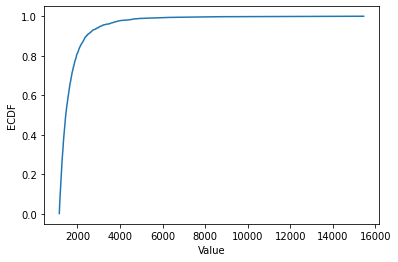

In [18]:
cdf = user_anime['anime_count'].value_counts().sort_index().cumsum()

plt.plot(list(cdf.index), cdf/cdf.max())
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.ylim([-0.05,1.05])
plt.show()

In [19]:
filtered_users = user_anime[user_anime['anime_count'] > 280]
users = set(filtered_users['user_id'])
rating_data = rating_top_anime[rating_top_anime['user_id'].isin(users)]

In [20]:
unique_users = {int(x): i for i,x in enumerate(rating_data['user_id'].unique())}
unique_items = {int(x): i for i,x in enumerate(anime_df['MAL_ID'].unique())}

anime_collabolative_filter = np.zeros((len(unique_items), len(unique_users)))

for user_id, anime_id, rating in rating_data.values:
    anime_collabolative_filter[unique_items[anime_id], unique_users[user_id]] = rating

In [21]:
cf_model_knn = NearestNeighbors(metric='cosine', n_neighbors=9)
cf_model_knn.fit(csr_matrix(anime_collabolative_filter))

NearestNeighbors(metric='cosine', n_neighbors=9)

In [22]:
def cf_recommend_anime(query_index):
    distances, indices = cf_model_knn.kneighbors(anime_collabolative_filter[query_index,:].reshape(1, -1), n_neighbors=11)
    result = []
    for i in range(0, len(distances.flatten())):
        index = indices.flatten()[i]
        if index == query_index:
            continue
        result.append(anime_df.iloc[index])
        
    return pd.DataFrame(result)

In [23]:
cf_recommend_anime(search_anime('進撃の巨人'))

                                                    Name  \
7449                                  Shingeki no Kyojin   
7879                              Shingeki no Kyojin OVA   
8052                     Shingeki no Kyojin: Ano Hi Kara   
8068                    Shingeki no Kyojin Picture Drama   
9018         Shingeki no Kyojin Movie 1: Guren no Yumiya   
9019        Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa   
9383                         Shingeki no Kyojin Season 2   
9384                 Shingeki no Kyojin: Kuinaki Sentaku   
12946         Shingeki no Kyojin-ten 360° Taikan Theater   
13252                        Shingeki no Kyojin Season 3   
13428                     Shingeki no Kyojin: Lost Girls   
13804  Shingeki no Kyojin Season 2 Movie: Kakusei no ...   
13999      Animegatari x Shingeki no Kyojin Collab Eizou   
14963                 Shingeki no Kyojin Season 3 Part 2   
15626               Shingeki no Kyojin Season 3 Specials   
15627  Shingeki no Kyojin in the Dome: H

,MAL_ID,Name,Genres,Type,Producers,Source,Completed,Japanese name,English name,Score
10451,30276,One Punch Man,"Action, Sci-Fi, Comedy, Parody, Super Power, S...",TV,"TV Tokyo, Bandai Visual, Lantis, Asatsu DK, Ba...",Web manga,1841220,ワンパンマン,One Punch Man,8.57
6614,11757,Sword Art Online,"Action, Game, Adventure, Romance, Fantasy",TV,"Aniplex, Genco, DAX Production, ASCII Media Wo...",Light novel,1907261,ソードアート・オンライン,Sword Art Online,7.25
8148,19815,No Game No Life,"Game, Adventure, Comedy, Supernatural, Ecchi, ...",TV,"Frontier Works, Media Factory, Movic, AT-X",Light novel,1426896,ノーゲーム・ノーライフ,"No Game, No Life",8.2
9383,25777,Shingeki no Kyojin Season 2,"Action, Military, Mystery, Super Power, Drama,...",TV,"Production I.G, Dentsu, Mainichi Broadcasting ...",Manga,1337762,進撃の巨人 Season2,Attack on Titan Season 2,8.45
4636,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,"Aniplex, Dentsu, Mainichi Broadcasting System,...",Original,1229098,Angel Beats!（エンジェルビーツ）,Angel Beats!,8.15
5683,9253,Steins;Gate,"Thriller, Sci-Fi",TV,"Frontier Works, Media Factory, Movic, AT-X, Ka...",Visual novel,1134756,STEINS;GATE,Steins;Gate,9.11
8292,20507,Noragami,"Action, Adventure, Comedy, Supernatural, Shounen",TV,"Avex Entertainment, Dentsu, Shochiku, Kodansha...",Manga,1181215,ノラガミ,Noragami:Stray God,8.01
8646,22319,Tokyo Ghoul,"Action, Mystery, Horror, Psychological, Supern...",TV,"Marvelous AQL, TC Entertainment, Shueisha",Manga,1594880,東京喰種-トーキョーグール-,Tokyo Ghoul,7.81
7323,15809,Hataraku Maou-sama!,"Comedy, Demons, Supernatural, Romance, Fantasy",TV,"Sotsu, Lantis, Pony Canyon, Magic Capsule, Inf...",Light novel,839612,はたらく魔王さま!,The Devil is a Part-Timer!,7.83
1431,1575,Code Geass: Hangyaku no Lelouch,"Action, Military, Sci-Fi, Super Power, Drama, ...",TV,"Bandai Visual, Mainichi Broadcasting System, B...",Original,1209288,コードギアス 反逆のルルーシュ,Code Geass:Lelouch of the Rebellion,8.72
